# Land mask data preparation

We are going to use the intermidiate data from eez, in order to create a dataset that can be used as a land mask.
The steps are:
1. Load eez
2. merge the eez dataset with the iso3 codes
3. disaggregate the eez dataset based on the iso3 codes and subdivide the eez into smaller polygons


In [1]:
import geopandas as gpd
from pathlib import Path
from tqdm.asyncio import tqdm
import multiprocessing
import psutil
from functools import lru_cache
import math
import asyncio
from shapely.geometry import Polygon
from shapely.ops import unary_union
import time
import pandas as pd
from typing import List, Dict, Union
import sys

scripts_dir = Path("..").joinpath("src")
if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir.resolve().as_posix())

from data_commons.loader import load_regions, load_locations_code
from pipelines.output_schemas import ProtectedAreaExtentSchema

In [2]:
def load_shapefile(path: str, np: int = 1):
    """Load shapefile into dask GeoDataFrame."""
    df = gpd.read_file(path)
    df.geometry = df.geometry.make_valid()
    return df

In [3]:
# Paths & data loading
basepath = Path("/home/mambauser/notebooks")
eez_path = basepath.parent.joinpath("data/eez_intermediate/eez_intermediate/eez_intermediate.shp")
mpas_path = basepath.parent.joinpath("data/mpa_intermediate/mpa_intermediate/mpa_intermediate.shp")
output_file = basepath.parent.joinpath("data/mpa_intermediate/mpa_landmask/mpa_landmask.shp")
output_file.parent.mkdir(parents=True, exist_ok=True)
eez = load_shapefile(eez_path.as_posix(), 10)  # 200nm EEZ
mpas = load_shapefile(mpas_path.as_posix(), 100)  # MPAs

In [3]:
@lru_cache
def get_system_info(MIN_MEMORY_WORKER=8):
    """Get system info."""
    cpu_count = multiprocessing.cpu_count()
    available_memory = psutil.virtual_memory().available / (1024.0**3)
    recommended_partitions = math.floor(available_memory / MIN_MEMORY_WORKER)
    return {
        "cpu_count": cpu_count,
        "total_memory": psutil.virtual_memory().total / (1024.0**3),
        "available_memory": available_memory,
        "recommended_partitions": recommended_partitions
        if recommended_partitions < cpu_count
        else (cpu_count-1),
    }

In [5]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

In [4]:
def collection_to_multipolygon(geometry_collection):
    """Convert collection of polygons to multipolygon."""
    print(type(geometry_collection.geoms))
    geom_list = [
        geom
        for geom in geometry_collection.geoms
        if geom.geom_type == "Polygon" or geom.geom_type == "MultiPolygon"
    ]
    return unary_union(geom_list)


def repair_geometry(geom):
    if not geom:
        return Polygon()
    elif not geom.is_valid:
        geom = collection_to_multipolygon(geom.buffer(0.0).make_valid())
    elif geom.geom_type == "GeometryCollection":
        geom = collection_to_multipolygon(geom)
    return geom

In [6]:
def calc_area(df: pd.DataFrame):
    """Calculate area."""
    return df.assign(area=df.geometry.to_crs("ESRI:53009").area/1e6)

In [7]:
def get_matches(geom, df):
    """Get matches."""
    candidates = df.iloc[df.sindex.intersection(geom.bounds)]
    if len(candidates) > 0:
        candidates = candidates[candidates.intersects(geom)]
    return candidates

In [8]:
def arrange_dimensions(geodataframeA, geodataframeB):
    """Arrange dimensions."""
    return (
        (geodataframeA, geodataframeB)
        if geodataframeA.shape[0] < geodataframeB.shape[0]
        else (geodataframeB, geodataframeA)
    )


def set_operation_geometry(geometryA, geometryB, ops="intersection"):
    """Set geometry."""
    operation = getattr(geometryA, ops)
    return repair_geometry(operation(geometryB))


@background
def overlay_chunk(row_small, df_large, pbar, operation, reverse):
    candidates = get_matches(row_small.geometry, df_large.geometry)
    if len(candidates) > 0:
        subset_geometry = (
            set_operation_geometry(row_small.geometry, candidates.geometry.unary_union, operation)
            if not reverse
            else set_operation_geometry(
                candidates.geometry.unary_union, row_small.geometry, operation
            )
        )
    pbar.update(1)

    return subset_geometry


@background
def spatial_join_chunk(row_small, df_large, pbar):
    test_row = gpd.GeoDataFrame([row_small], crs=df_large.crs)
    candidates = get_matches(row_small.geometry, df_large.geometry)
    subset = df_large.iloc[candidates.index]
    if len(candidates) > 0:
        result = subset.sjoin(test_row, how="inner").clip(test_row.geometry).reset_index(drop=True)
        result.geometry = result.geometry.apply(repair_geometry)
    else:
        result = gpd.GeoDataFrame(columns=test_row.columns)
    pbar.update(1)
    return result


async def overlay(geodataframeA, geodataframeB, operation="intersection", reverse=False):
    """Create difference between two GeoDataFrames."""
    # we build the spatial index for the larger GeoDataFrame
    smaller_dim, larger_dim = arrange_dimensions(geodataframeA, geodataframeB)
    with tqdm(total=smaller_dim.shape[0]) as pbar:  # we create a progress bar
        new_df = await asyncio.gather(
            *(overlay_chunk(row, larger_dim, pbar, operation, reverse) for row in smaller_dim)
        )
    return gpd.GeoDataFrame(new_df, crs=smaller_dim.crs)


async def spatial_join(geodataframeA, geodataframeB):
    """Create difference between two GeoDataFrames."""
    # we build the spatial index for the larger GeoDataFrame
    smaller_dim, larger_dim = arrange_dimensions(geodataframeA, geodataframeB)
    with tqdm(total=smaller_dim.shape[0]) as pbar:  # we create a progress bar
        new_df = await asyncio.gather(
            *(
                spatial_join_chunk(row, larger_dim, pbar)
                for row in smaller_dim.itertuples(index=False)
            )
        )
    return gpd.GeoDataFrame(pd.concat(new_df, ignore_index=True), crs=smaller_dim.crs)

In [13]:
@background
def spatial_dissolve_chunk(i, gdf, pbar, _by, _aggfunc):
    result = (
        gdf[gdf["year"] <= i]
        .dissolve(by=_by, aggfunc=_aggfunc)
        .assign(year=i)
        .reset_index()
        .pipe(calc_area)
        .drop(columns=["geometry"])
    )
    pbar.update(1)
    return result

In [9]:
def reduce_location_iso(df: pd.DataFrame, iso_cols: List[str] = ["ISO_SOV1", "ISO_SOV2", "ISO_SOV3"]) -> pd.DataFrame:
    # Create new column "iso" that has the field "ISO_SOV1" for all rows except those in which ISO_SOV2 and ISO_SOV3 are not null. In such cases concatenate ISO_SOV1, ISO_SOV2 and ISO_SOV3
    def reduce_iso(row):
        filtered_isos = filter(lambda iso: isinstance(iso, str), row)

        return ";".join(list(filtered_isos))

    return df.assign(iso=lambda row: row[iso_cols].apply(reduce_iso, axis=1))

In [11]:
def assign_iso3(df):
    """Assign ISO3 code."""
    def set_iso3(row):
        return (
            row["PARENT_ISO"]
            if (row["POL_TYPE"] == "200NM" and row["PARENT_ISO"] != row["iso"] and len(row["PARENT_ISO"])<=4)
            else row["iso"]
        )

    return df.assign(iso_3=df.apply(lambda row: set_iso3(row), axis=1))

In [12]:
def split_by_year(gdf: gpd.GeoDataFrame, year_col: str = "STATUS_YR", year_val=2010) -> List[gpd.GeoDataFrame]:
    """Split data by year."""
    prior_2010 = (gdf[gdf[year_col] <= year_val].dissolve(
        by=["PA_DEF", "iso_3"],
        aggfunc={
            "PA_DEF": "count",
        },
    )
    .assign(year=2010)
    .rename(columns={"PA_DEF": "protectedAreasCount"})
    .reset_index())
    after_2010 = (
        gdf[gdf["STATUS_YR"] > 2010][["iso_3", "STATUS_YR", "PA_DEF", "geometry"]]
        .assign(protectedAreasCount=1)
        .rename(columns={"STATUS_YR": "year"})
    )
    return [prior_2010, after_2010]

In [14]:
async def spatial_dissolve(gdf, loop, by, aggfunc):
    """Create difference between two GeoDataFrames."""
    # we build the spatial index for the larger GeoDataFrame
    base = split_by_year(gdf)

    result_to_iter = pd.concat(base, ignore_index=True).copy()

    with tqdm(total=len(loop)) as pbar:  # we create a progress bar
        new_df = await asyncio.gather(
            *(spatial_dissolve_chunk(year, result_to_iter, pbar, by, aggfunc) for year in loop)
        )
    return pd.concat(
        [base[0].pipe(calc_area).drop(columns=["geometry"]), *new_df], ignore_index=True
    )

In [15]:
def calculate_global_area(
    df: pd.DataFrame,
    gby_col: list,
    agg_ops: Dict[str, str] = {"area_km2": "sum"},
    iso_column="location_i",
) -> pd.DataFrame:
    global_area = df.groupby([*gby_col]).agg(agg_ops).reset_index().assign(**{iso_column: "GLOB"})
    return pd.concat([global_area, df], ignore_index=True)

In [16]:
def separate_parent_iso(df: pd.DataFrame, iso_column="location_i", separator=";") -> pd.DataFrame:
    df[iso_column] = (
        df[iso_column].str.replace(" ", "").str.replace(":", separator).str.split(separator)
    )
    return df.explode(iso_column)

In [17]:
def add_region_iso(df: pd.DataFrame, iso_column) -> pd.DataFrame:
    regions = load_regions()

    def find_region_iso(iso: str) -> Union[str, None]:
        filtered_regions = list(filter(lambda x: iso in x["country_iso_3s"], regions.get("data")))
        return filtered_regions[0]["region_iso"] if len(filtered_regions) > 0 else None

    return df.assign(region=lambda row: row[iso_column].apply(find_region_iso))

In [18]:
def calculate_stats_cov(
    df: pd.DataFrame, gby_col: list, iso_column: str, area_column: str = "area_km2", count_col:str = "geometry"
) -> pd.DataFrame:
    regions = (
        df.groupby([*gby_col, "region"])
        .agg({area_column: "sum",count_col: "sum"})
        .reset_index()
        .rename(columns={"region": iso_column})
    )

    return pd.concat(
        [
            regions,
            df.groupby([*gby_col, iso_column])
            .agg({area_column: "sum", count_col: "sum"})
            .reset_index(),
        ],
        ignore_index=True,
    )

In [19]:
def coverage_stats(
    df: pd.DataFrame,
    area_col: str = "area",
    sort_vals: List[str] = ["iso_3", "year", "PA_DEF"],
) -> pd.DataFrame:
    return df.assign(
        cumSumProtectedArea=df[area_col].round(2),
        protectedArea=(
            df.sort_values(by=sort_vals)[area_col]
            - df.sort_values(by=sort_vals)
            .groupby(sort_vals)[area_col]
            .shift(-1, fill_value=0)
            .reset_index(drop=True)
        ).round(2),
    )

In [20]:
def output(
    df: pd.DataFrame, iso_column: str, rep_d: dict, rename: Dict[str, str], drop_cols: List[str]
) -> pd.DataFrame:
    """ """
    if iso_column:
        locations_code = load_locations_code()
        df = df.join(locations_code.set_index("code"), on=iso_column, how="left")
    return (
        df.replace(rep_d)
        .rename(columns=rename)
        .drop(columns=drop_cols)
        .assign(
            id=df.index + 1,
        )
        .set_index("id")
    )

In [38]:
filtered = mpas[mpas["STATUS"] != "Proposed"].reset_index()  # Remove proposed MPAs

In [39]:
test_data = await spatial_join(eez, filtered)

100%|██████████| 282/282 [06:24<00:00,  1.36s/it]


In [40]:
subset_all = test_data.pipe(reduce_location_iso).pipe(assign_iso3)

In [41]:
subset_all.to_file(output_file.parent.joinpath("test_sjoin.shp"), driver="ESRI Shapefile")

In [42]:
final_data = await spatial_dissolve(
    subset_all,
    range(2011, time.localtime().tm_year + 1),
    ["PA_DEF", "iso_3"],
    {"protectedAreasCount": "sum"},
    
)

100%|██████████| 14/14 [02:47<00:00, 11.98s/it]


In [43]:
final_data

,PA_DEF,iso_3,protectedAreasCount,year,area
0,0,COL,2,2010,3295.358445
1,0,MAR,6,2010,4.238628
2,0,PHL,24,2010,31956.310701
3,1,ABNJ,28,2010,904820.541380
4,1,AGO,1,2010,0.048698
...,...,...,...,...,...
2371,1,VNM,33,2024,3353.540067
2372,1,VUT,5,2024,18.148840
2373,1,WSM,2,2024,99.018822
2374,1,YEM,1,2024,1262.298532


In [44]:
coverage = (
    final_data.pipe(calculate_global_area, ["year", "PA_DEF"], {"area": "sum"}, "iso_3")
    .pipe(separate_parent_iso, "iso_3")
    .pipe(add_region_iso, "iso_3")
    .replace(
        {
            "iso_3": {
                "ATA":"ABNJ",
                "COK": "NZL",
                "IOT": "GBR",
                "NIU": "NZL",
                "SHN": "GBR",
                "SJM": "NOR",
                "UMI": "USA",
                "NCL": "FRA",
                "GIB": "GBR",
            }
        }
    )
    .pipe(calculate_stats_cov, ["year", "PA_DEF"], "iso_3", "area", "protectedAreasCount")
    .pipe(coverage_stats)
)

In [45]:
coverage.groupby(["iso_3", "year"]).agg({"area": "sum"}).reset_index().to_csv(
    output_file.parent.joinpath("mpa_landmask_v4.csv"), index=False
)

In [46]:
ProtectedAreaExtentSchema(
    coverage.pipe(
        output,
        "iso_3",
        {"PA_DEF": {"0": 2, "1": 1}},
        {"PARENT_NAME": "location", "PA_DEF": "protection_status"},
        ["area", "iso_3"],
    )
).to_csv(
    output_file.parent.joinpath("mpa_landmask_strapi.csv"),
    index=True,
)

### QA Assessments

In [ ]:
#!apt-get install chromium chromium-driver

In [169]:
#!micromamba install -y -c conda-forge selenium

In [61]:
from pathlib import Path
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

In [162]:
our_data_coverage = pd.read_csv(output_file.parent.joinpath("mpa_landmask_v3.csv"))

In [166]:
def get_protected_area_extent(iso: str):
    URL = f"https://www.protectedplanet.net/country/{iso}"

    # Define the Chrome webdriver options
    opt = webdriver.ChromeOptions()
    opt.add_argument("--headless")
    opt.add_argument("--no-sandbox")
    opt.add_argument("--disable-dev-shm-usage")

    # Pass the defined options objects to initialize the web driver
    service = webdriver.ChromeService(executable_path="/usr/bin/chromedriver")
    # driver = webdriver.Chrome(options=opt)
    driver = webdriver.Chrome(
        service=service,
        options=opt
    )
    driver.get(URL)
    time.sleep(1)

    data = driver.find_elements(By.CLASS_NAME, "card__stat")

    marine_data = list(filter(lambda x: "Marine and coastal area covered" in x.text, data ))
    if len(marine_data) == 1:
        return marine_data[0].text.split("\n")[0][:-3]
    else:
        return None

In [167]:
our_2023 = our_data_coverage[our_data_coverage["year"] == 2023].reset_index(drop=True)
our_2023

,year,iso_3,protectedArea
0,2023,ABNJ,1442656.56
1,2023,AF,805198.20
2,2023,AGO,0.05
3,2023,ALB,139.01
4,2023,ARE,6256.92
...,...,...,...
147,2023,VUT,1384.39
148,2023,WA,17462.58
149,2023,WSM,99.02
150,2023,YEM,1271.95


In [168]:
compare = our_2023.assign(protectedAreaExtent=our_2023["iso_3"].apply(get_protected_area_extent))

In [180]:
compare

,year,iso_3,protectedArea,protectedAreaExtent
0,2023,ABNJ,1442656.56,None
1,2023,AF,805198.20,None
2,2023,AGO,0.05,67
3,2023,ALB,139.01,318
4,2023,ARE,6256.92,"6,281"
...,...,...,...,...
147,2023,VUT,1384.39,48
148,2023,WA,17462.58,None
149,2023,WSM,99.02,191
150,2023,YEM,1271.95,"2,562"


TypeError: 'value' must be an instance of str or bytes, not a float

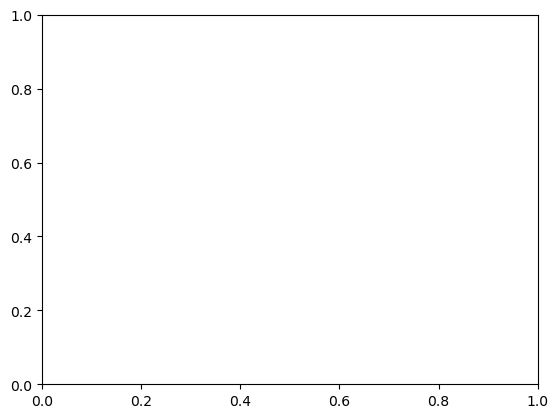

In [179]:
compare[compare.notnull()].plot.scatter(x="protectedAreaExtent", y="protectedArea", c="DarkBlue")